In [69]:
!nvidia-smi

Sat Jan 25 09:40:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K20Xm         On   | 00000000:08:00.0 Off |                    0 |
| N/A   47C    P0    57W / 235W |   5485MiB /  5700MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K20Xm         On   | 00000000:84:00.0 Off |                    0 |
| N/A   52C    P0    56W / 235W |   5485MiB /  5700MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [145]:
go = False
if go:
    
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
    import tensorflow as tf
    from keras import backend as K

    set_gpu=True

    if set_gpu:
        os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";  # The GPU id to use, usually either "0" or "1";
        os.environ["CUDA_VISIBLE_DEVICES"]="0";  # Do other imports now...
        print(os.environ["CUDA_VISIBLE_DEVICES"])


        num_cores = 39

        GPU=True
        CPU=False

        if GPU:
            num_GPU = 1
            num_CPU = 1
        if CPU:
            num_CPU = 1
            num_GPU = 0

        config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                                inter_op_parallelism_threads=num_cores, 
                                allow_soft_placement=True,
                                device_count = {'CPU' : num_CPU,
                                                'GPU' : num_GPU}
                               )

        session = tf.Session(config=config)
        K.set_session(session)


In [146]:
#!wget https://raw.githubusercontent.com/DBertazioli/host/master/datas/df_final_processed.csv

In [1]:
#!pip install pyforest
#from pyforest import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import keras

Using TensorFlow backend.
/opt/intel/intelpython3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/intel/intelpython3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/intel/intelpython3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/intel/intelpython3/lib/python3.6/site-packages/t

In [2]:
df_harmonics = pd.read_csv("../data/output/harmonics.csv", index_col=0)
df_harmonics.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9
1,1,0.192241,0.111166,0.017747,-0.012548,0.033027,-0.010471,0.014676,-0.007925
2,2,0.097356,0.057627,-0.001360,0.004587,0.072702,0.000261,0.014648,0.005893
3,3,-0.021915,-0.011354,-0.020139,0.020487,0.107396,0.010978,0.014621,0.019311
4,4,-0.135697,-0.077292,-0.034058,0.030868,0.134730,0.021047,0.014593,0.031421
5,5,-0.215488,-0.122519,-0.039756,0.032934,0.152834,0.029876,0.014565,0.041401


In [3]:
df = pd.read_csv("../data/df_final_processed.csv", index_col = 0)
df.head()

from keras.preprocessing.sequence import TimeseriesGenerator

#some zeroes
#series = df.level_scaled.values
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0.01, 1))

series = sc.fit_transform(df.level.values.reshape(-1, 1))

split_index = -7*24

#test_series = series [split_index:]
#series = series [:split_index]
#series = series.reshape((len(series), n_features))
#test_series = test_series.reshape((len(test_series), n_features))

series.shape

(78888, 1)

In [4]:
sc_harmonics_list = []
harmonics_list = []
for col in df_harmonics.columns[1:]:
    #print(col)
    sc_harm = MinMaxScaler()
    harmonics_list.append(sc_harm.fit_transform(df_harmonics[col].values.reshape(-1, 1)))
    sc_harmonics_list.append(sc_harm)

In [5]:
sc_rain = MinMaxScaler()
rain = sc_rain.fit_transform(df.rain.values.reshape(-1, 1))

sc_wind = MinMaxScaler()
vel_wind = sc_wind.fit_transform(df.vel_wind.values.reshape(-1, 1))

sc_dir_wind = MinMaxScaler()
dir_wind = sc_dir_wind.fit_transform(df.dir_wind.values.reshape(-1, 1))

sc_lunar = MinMaxScaler()
lunar = sc_lunar.fit_transform(df.inv_dist.values.reshape(-1, 1))


In [6]:
harmonics_list.extend([series, rain, vel_wind, dir_wind])

len(harmonics_list),#harmonics_list

(12,)

In [7]:
input_series = np.hstack(harmonics_list)
input_series.shape

(78888, 12)

In [8]:
input_series[:,-8], series

(array([0.60277651, 0.72624026, 0.83420205, ..., 0.22447491, 0.34219187,
        0.47072182]), array([[0.766 ],
        [0.757 ],
        [0.694 ],
        ...,
        [0.3475],
        [0.3205],
        [0.2935]]))

In [9]:
# 24h ahead single preds
# steps_ahead = 24-1
# padded_series = np.expand_dims(np.concatenate([series.flatten(), np.zeros(steps_ahead)]), axis = -1)
# padded_series

# target_series = np.roll(padded_series, -steps_ahead)[:series.shape[0]] #need to discard the last as well

In [10]:
# target_series = target_series[:-steps_ahead]  #removing the zero padding
# series = series[:-steps_ahead] #removing the zero padding
# input_series = input_series[:-steps_ahead]
target_series = series #backward compatibility :)
series.shape, target_series.shape, input_series.shape

((78888, 1), (78888, 1), (78888, 12))

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, CuDNNLSTM, LeakyReLU, Dropout, BatchNormalization
from keras.utils import multi_gpu_model
from keras import backend as K
from keras.optimizers import Adam 


# define model
def make_model(n_input, n_features, 
               verbose = False, multi = True, use_CuDNNLSTM = True,
              loss = "mse", metrics = ["mae", "mape"], opt = "adam",
              lr = 0.001, batch_size = 512, reg = True):
    K.clear_session()
    LSTM_layer = LSTM if not use_CuDNNLSTM else CuDNNLSTM
    if opt == "adam":
        opt = Adam (lr = lr )
    else:
        opt = opt
    
    model = Sequential()
    
    model.add(LSTM_layer(1024, input_shape=(n_input, n_features), return_sequences=True))
    if reg:
        model.add(BatchNormalization())
    model.add(LeakyReLU())
    if reg:
        model.add(Dropout(rate = 0.5))
    for i in range(1):
        model.add(LSTM_layer(512, return_sequences=True))
        if reg:
            model.add(BatchNormalization())
        model.add(LeakyReLU())
        if reg:
            model.add(Dropout( rate = 0.4))
    
    for i in range(1):
        model.add(LSTM_layer(256, return_sequences = False))
        if reg:
            model.add(BatchNormalization())
        model.add(LeakyReLU())
        if reg:
            model.add(Dropout(rate = 0.3))

    model.add(Dense(128))
    model.add(LeakyReLU())
    if reg:
        model.add(Dropout(rate = 0.2))
    
    model.add(Dense(1))
    
    model.compile(optimizer=opt, loss=loss, metrics = metrics)
    if verbose:
        model.summary()
    if multi:
        mmodel = multi_gpu_model(model, 2)
        mmodel.compile(optimizer=opt, loss=loss, metrics = metrics)
        return mmodel, model
    else: 
        
        return None, model

In [62]:
n_input = 1*3

train_generator = TimeseriesGenerator(input_series, target_series, start_index=0, end_index=len(series) + split_index-1, length=n_input, batch_size=1)
#val_generator = TimeseriesGenerator(series, target_series, start_index=len(series) + 2*split_index-n_input, end_index=len(series)+split_index-1, length=n_input, batch_size=1)
test_generator = TimeseriesGenerator(input_series, target_series, start_index=len(series) + split_index -n_input, end_index=len(series)-1, length=n_input, batch_size=1)

In [63]:
len(train_generator), len(test_generator)

(78717, 168)

In [64]:
train_list = []
test_list = []
for train,test in train_generator:
    train_list.append(train)
    test_list.append(test)
train_input = np.concatenate(train_list, axis = 0)
train_targets = np.concatenate(test_list, axis = 0)
train_input.shape, train_targets.shape

((78717, 3, 12), (78717, 1))

In [65]:
train_list = []
test_list = []
for train, test in test_generator: #some weird but with the last access
    train_list.append(train)
    test_list.append(test)

    
test_input = np.concatenate(train_list, axis = 0)
test_targets = np.concatenate(test_list, axis = 0)
test_input.shape, test_targets.shape

((168, 3, 12), (168, 1))

In [66]:
import wandb
wandb.login()


True

In [67]:
from wandb.keras import WandbCallback as wb

wandb.init(project = "venice_is_drowing", name = f"lstm_single_output_test_1h_{n_input}_input_{input_series.shape[1]}_feat")
cfg = wandb.config
batch_size = 256
cfg.batch_size = batch_size
cfg.n_features = input_series.shape[1]
cfg.n_input = n_input
cfg.epochs = 250

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [68]:
mmodel, model = make_model(n_input, input_series.shape[1], opt = "adam", lr = 0.001, reg = True, 
                           multi = True, use_CuDNNLSTM = True, verbose = True,
                           loss = "mse", metrics = ["mse","mae", "mape"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 3, 1024)           4251648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 1024)           4096      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3, 1024)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 3, 512)            3149824   
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 512)            2048      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 3, 512)            0         
__________

In [69]:
# try again with mape loss 1*24 and 1*7*24

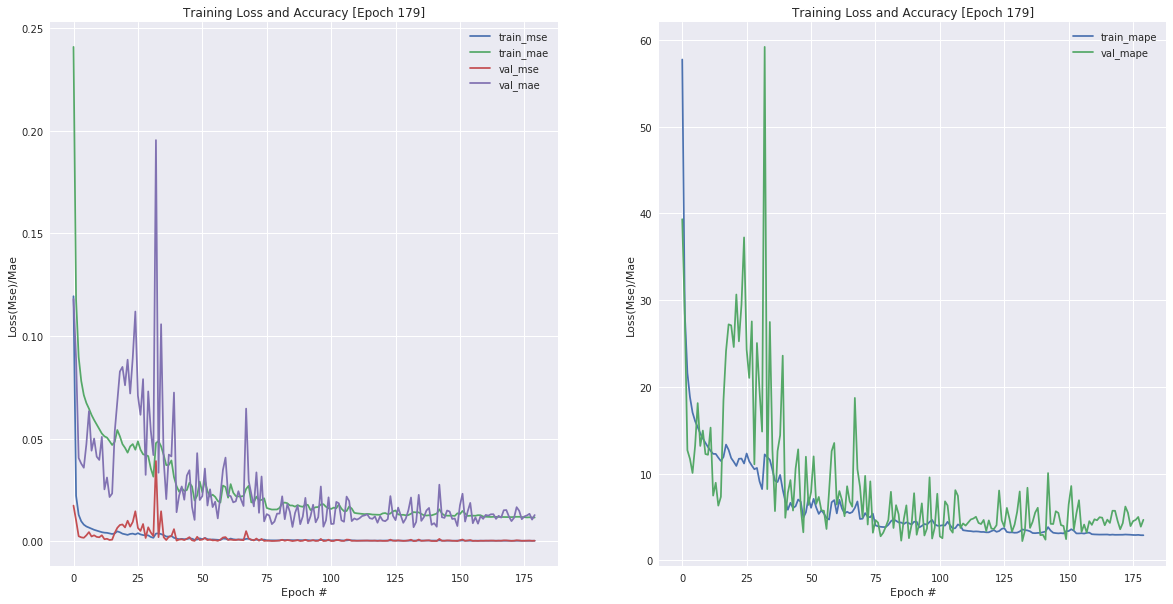

Epoch 181/250
78717/78717 [==============================] - 16s 203us/step - loss: 2.3304e-04 - mean_squared_error: 2.3304e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 2.9049 - val_loss: 1.8281e-04 - val_mean_squared_error: 1.8281e-04 - val_mean_absolute_error: 0.0101 - val_mean_absolute_percentage_error: 3.7374
Epoch 182/250
78717/78717 [==============================] - 16s 205us/step - loss: 2.3540e-04 - mean_squared_error: 2.3540e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 2.9049 - val_loss: 2.1536e-04 - val_mean_squared_error: 2.1536e-04 - val_mean_absolute_error: 0.0110 - val_mean_absolute_percentage_error: 4.0943
Epoch 183/250
78717/78717 [==============================] - 16s 204us/step - loss: 2.3720e-04 - mean_squared_error: 2.3720e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 2.9231 - val_loss: 2.9432e-04 - val_mean_squared_error: 2.9432e-04 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_

In [70]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from myutils import TrainingPlot


plot_losses = TrainingPlot()
es = EarlyStopping(monitor = "val_loss", patience = 50, restore_best_weights = True, verbose = 1)
rl = ReduceLROnPlateau(monitor = "val_loss", patience = 25, cooldown=10, factor=0.5, verbose = 1)

# fit model
history = mmodel.fit(
    train_input, train_targets,
    epochs=cfg.epochs,
    batch_size = cfg.batch_size, 
    
    verbose=1, 
    shuffle = False,
    
    #validation_data=ttest_generator, 
    #validation_steps = 6,
    validation_data = (test_input, test_targets),
    
    callbacks=[plot_losses, 
              es, rl,
              wb(log_gradients=False, log_weights=False)
              ]
)

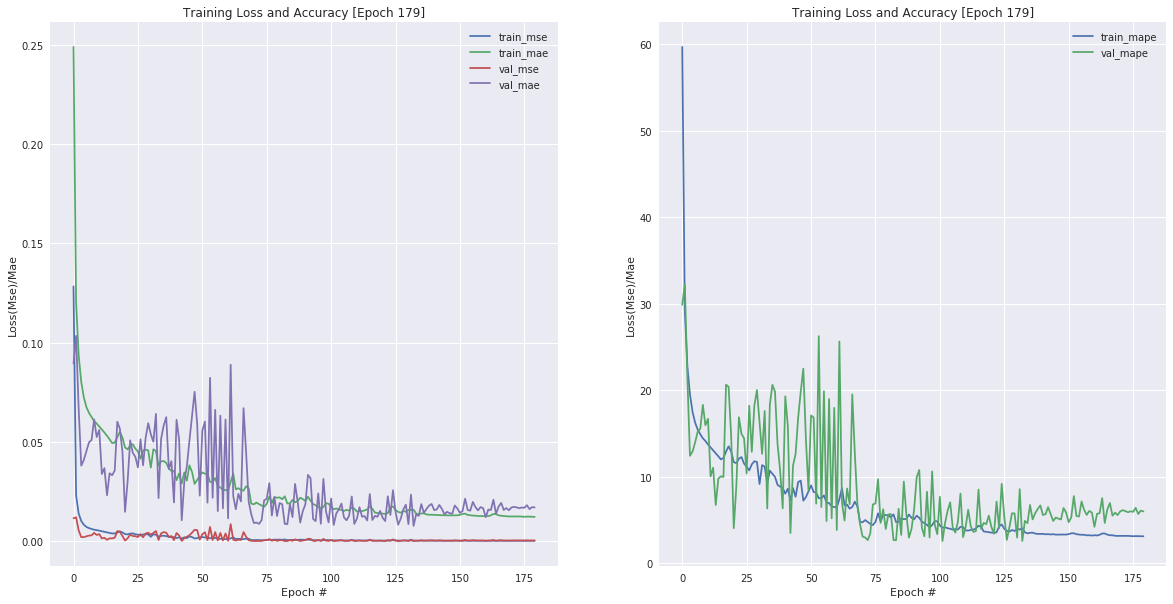

Epoch 181/250
78718/78718 [==============================] - 15s 186us/step - loss: 2.6435e-04 - mean_squared_error: 2.6435e-04 - mean_absolute_error: 0.0123 - mean_absolute_percentage_error: 3.1140 - val_loss: 3.7592e-04 - val_mean_squared_error: 3.7592e-04 - val_mean_absolute_error: 0.0164 - val_mean_absolute_percentage_error: 5.6805
Epoch 182/250
78718/78718 [==============================] - 15s 189us/step - loss: 2.6632e-04 - mean_squared_error: 2.6632e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 3.1080 - val_loss: 4.4144e-04 - val_mean_squared_error: 4.4144e-04 - val_mean_absolute_error: 0.0177 - val_mean_absolute_percentage_error: 6.2140
Epoch 183/250
78718/78718 [==============================] - 15s 188us/step - loss: 2.6071e-04 - mean_squared_error: 2.6071e-04 - mean_absolute_error: 0.0122 - mean_absolute_percentage_error: 3.0820 - val_loss: 4.2995e-04 - val_mean_squared_error: 4.2995e-04 - val_mean_absolute_error: 0.0172 - val_mean_absolute_percentage_

In [39]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from myutils import TrainingPlot


plot_losses = TrainingPlot()
es = EarlyStopping(monitor = "val_loss", patience = 50, restore_best_weights = True, verbose = 1)
rl = ReduceLROnPlateau(monitor = "val_loss", patience = 25, cooldown=10, factor=0.5, verbose = 1)

# fit model
history = mmodel.fit(
    train_input, train_targets,
    epochs=cfg.epochs,
    batch_size = cfg.batch_size, 
    
    verbose=1, 
    shuffle = False,
    
    #validation_data=ttest_generator, 
    #validation_steps = 6,
    validation_data = (test_input, test_targets),
    
    callbacks=[plot_losses, 
              es, rl,
              wb(log_gradients=False, log_weights=False)
              ]
)

In [71]:
model.evaluate(test_input,test_targets)

168/168 [==============================] - 0s 2ms/step


[7.363700743077235e-05,
 7.363700743077235e-05,
 0.006855809440215428,
 2.2298269953046526]

In [72]:
real_preds = model.predict(test_input).flatten() #iterated predictions on real data
real_data = test_targets.flatten()


In [42]:
test_input.shape

(168, 2, 12)

In [74]:
def iterate_prediction(input_seq = series[-n_input+split_index:split_index], pred_len = 168):
    init_test_arr = np.expand_dims(input_seq, axis = 0)
    preds = []
    for i in range(pred_len):
        #if i < 24: #evaluate on real data for 
        #    pred = model.predict(test_input[i:i+1], )[0][0]
        #    preds.append(pred)
        #else:
        test_features = np.squeeze(np.squeeze(init_test_arr, axis = -1), axis = 0).tolist()
        tmp = [test_input[i:i+1, :, j] for j in range(8)]
        #print(len(tmp), set([elem.shape for elem in tmp]))
        #print(init_test_arr.shape)
        #print(np.squeeze(init_test_arr, axis = -1).shape)
        tmp.append(np.squeeze(init_test_arr, axis = -1))
        #print(len(tmp), set([elem.shape for elem in tmp]))
        tmp1 = [test_input[i:i+1, :, j] for j in range(9,12)]
        #print(len(tmp1), set([elem.shape for elem in tmp1]))

        tmp.extend([test_input[i:i+1, :, j] for j in range(9,12)])
        #print(len(tmp), set([elem.shape for elem in tmp]))

        pred_input = np.array(tmp).reshape(1, 3, 12)
        #print(pred_input.shape)

        pred = model.predict(pred_input)[0][0]
        preds.append(pred)
        test_features.append(pred)
        init_test_arr = np.atleast_3d(test_features[-n_input:])

    return np.array(preds)

#preds = iterate_prediction()

In [83]:
real_preds = model.predict(test_input).flatten() #iterated predictions on real data
real_data = test_targets.flatten()
preds = iterate_prediction()
def calc_mape(real, pred):
    return (100*np.abs(real-pred)/real/real.shape[0]).sum()
print(calc_mape(real_data, real_preds)) #mape on real-data preds
print(calc_mape(real_data, preds)-12)  #mape on iterated preds #not really makes sense with 168 steps ahead
print(calc_mape(real_data[0:1], real_preds[0:1]))

2.2298270990930793
13.546643058100237
0.15917211314167945


In [84]:
#another attempt

In [53]:
def calc_mape(real, pred):
    return (100*np.abs(real-pred)/real/real.shape[0]).sum()
print(calc_mape(real_data, real_preds)) #mape on real-data preds
print(calc_mape(real_data, preds))  #mape on iterated preds #not really makes sense with 168 steps ahead
print(calc_mape(real_data[0:1], real_preds[0:1]))

2.551441272942235
18.255260411988083
0.2946116707541645


In [90]:
from sklearn.metrics import mean_squared_error
from math import sqrt


rmse_real_preds = sqrt(mean_squared_error(sc.inverse_transform(real_preds.reshape(-1, 1)), sc.inverse_transform(real_data.reshape(-1, 1))))
rmse_preds = sqrt(mean_squared_error(sc.inverse_transform(preds1.reshape(-1, 1)), sc.inverse_transform(real_data.reshape(-1, 1))) )
rmse_single_pred = sqrt(mean_squared_error(sc.inverse_transform(real_data[0:1].reshape(-1, 1)), sc.inverse_transform(real_preds[0:1].reshape(-1, 1))))

rmse_real_preds,rmse_preds,  rmse_single_pred

(1.906933568702198, 9.831135132287066, 0.1961364746093679)